# Welcome to the interactive Galaxy IPython Notebook.

You can access your data via the dataset number. Using a Python kernel, you can access dataset number 42 with ``handle = open(get(42), 'r')``.
To save data, write your data to a file, and then call ``put('filename.txt')``. The dataset will then be available in your galaxy history.
<br>When using a non-Python kernel, ``get`` and ``put`` are available as command-line tools, which can be accessed using system calls in R, Julia, and Ruby. For example, to read dataset number 42 into R, you can write ```handle <- file(system('get -i 42', intern = TRUE))```.
To save data in R, write the data to a file and then call ``system('put -p filename.txt')``.
Notebooks can be saved to Galaxy by clicking the large green button at the top right of the IPython interface.<br>
More help and informations can be found on the project [website](https://github.com/bgruening/docker-jupyter-notebook).

# RATECE-PLANICA ski station (Slovenia) under RCP 8.5 condition

## Is it worth investing in artificial snowmaking equipment at RATECE-PLANICA?

In [ ]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import cftime
import glob
import cdsapi
%matplotlib inline

## Adding your CDS API key 

- Login to [cds](https://cds.climate.copernicus.eu/)
- Visit page [How to install the cds api key](https://cds.climate.copernicus.eu/api-how-to#install-the-cds-api-key)
- Start a [new Terminal Session](https://jupyterlab.readthedocs.io/en/stable/user/terminal.html)
- Use `nano` to edit your cds api:

```
nano $HOME/.cdsapirc
```


# Step-1 : Get data for bias correction

## MPI-ESM-LR daily temperature from 1960 to end 2005

### Get MPI-ESM-LR 2m temperature data 

In [ ]:
c = cdsapi.Client()

c.retrieve(
    'projections-cmip5-daily-single-levels',
    {
        'ensemble_member': 'r1i1p1',
        'format': 'zip',
        'experiment': 'historical',
        'variable': '2m_temperature', 
        'model': 'mpi_esm_lr',
        'period': [
            '19600101-19691231', '19700101-19791231', '19800101-19891231',
            '19900101-19991231', '20000101-20051231',
        ],
    },
    'cmip5_mpi_esm_lr_daily_t2m.zip')

In [ ]:
# Save data into Galaxy history
!put -p cmip5_mpi_esm_lr_daily_t2m.zip -t zip

In [ ]:
!mkdir -p mpi_daily_h
!cd mpi_daily_h && unzip ../cmip5_mpi_esm_lr_daily_t2m.zip

### Compute 2 m temperature mean and standard deviation

In [ ]:
filenames = glob.glob('mpi_daily_h/tas_*_MPI-ESM-LR_*.nc')
print(filenames)
dset = xr.open_mfdataset(filenames, decode_times=True, use_cftime=True, combine='by_coords')

In [ ]:
dset

# Get data over Kranjska Gora station (1961-2005) 

- Select nearest grid point to Kranjska Gora station (46.5°N, 13.8°E, 800 m a.s.l.)
- time between 1961 and 2005.

In [ ]:
p = dset['tas'].loc['1961-01-01':'2005-12-31'].sel(lat=46.5,lon=13.8, method="nearest")

### Compute mean and standard deviation

In [ ]:
mean_mpi_1961_2005 = p.mean().values
std_mpi_1961_2005 = p.std().values
print(mean_mpi_1961_2005, std_mpi_1961_2005)

# Time series - daily RATECE-PLANICA average temperature

- coordinates: 46.50N, 13.70E, 864.0m
- GHCN-D station code: SIE00115206 RATECE-PLANICA Slovenia

In [ ]:
!wget http://berkeleyearth.lbl.gov/auto/Stations/TAVG/Text/22498-TAVG-Data.txt

In [ ]:
# Save data into Galaxy history
!put -p 22498-TAVG-Data.txt -t txt

# Read timeseries with pandas

In [ ]:
import pandas as pd

In [ ]:
filename = '22498-TAVG-Data.txt'
data = pd.read_csv(filename, sep='\s+', header=None, comment='%')

In [ ]:
mean_st_1961_2005 = data[(data[0] >= 1961 ) & (data[0] <= 2005)][6].mean()
std_st_1961_2005 = data[(data[0] >= 1961 ) & (data[0] <= 2005)][6].std()
print(mean_st_1961_2005 + 273.15, std_st_1961_2005)

In [ ]:
dset.close()

- We now have mean temperature and standard deviation for both MPI-ESM-LR historical and RATECE-PLANICA Slovenia meteorological station. These values will be used for our bias correction

# Step-2: Model data historical 1961 - 2005 
- 'maximum_2m_temperature_in_the_last_24_hours'
- 'minimum_2m_temperature_in_the_last_24_hours'

In [ ]:
c.retrieve(
    'projections-cmip5-daily-single-levels',
    {
        'ensemble_member': 'r1i1p1',
        'format': 'zip',
        'experiment': 'historical',
        'variable': [
            'maximum_2m_temperature_in_the_last_24_hours', 'minimum_2m_temperature_in_the_last_24_hours',
        ],
        'model': 'mpi_esm_lr',
        'period': [
            '19600101-19691231', '19700101-19791231', '19800101-19891231',
            '19900101-19991231', '20000101-20051231',
        ],
    },
    'cmip5_mpi_esm_lr_daily_tasmin_tasmax.zip')

In [ ]:
# Save data into Galaxy history
!put -p cmip5_mpi_esm_lr_daily_tasmin_tasmax.zip -t zip

In [ ]:
!mkdir -p mpi_daily_h
!cd mpi_daily_h && unzip ../cmip5_mpi_esm_lr_daily_tasmin_tasmax.zip && rm ../cmip5_mpi_esm_lr_daily_tasmin_tasmax.zip

# Apply bias correction to historical t2 min and t2 max 1961-2005

In [ ]:
filenames = glob.glob('mpi_daily_h/tas*_MPI-ESM-LR_*.nc')
print(filenames)
dset_hist = xr.open_mfdataset(filenames, decode_times=True, use_cftime=True, combine='by_coords')

## Apply bias correction to tasmin

In [ ]:
p = dset_hist['tasmin'].loc['1961-01-01':'2005-12-31'].sel(lat=46.5,lon=13.8, method="nearest")
t2min_h_bias_corrected = (p - mean_mpi_1961_2005)/std_mpi_1961_2005 * std_st_1961_2005 + mean_st_1961_2005

## Apply bias correction to tasmax

In [ ]:
p = dset_hist['tasmax'].loc['1961-01-01':'2005-12-31'].sel(lat=46.5,lon=13.8, method="nearest")
t2max_h_bias_corrected = (p - mean_mpi_1961_2005)/std_mpi_1961_2005 * std_st_1961_2005 + mean_st_1961_2005

### Select a year and make a plot

In [ ]:
t2max_h_bias_corrected.sel(time = t2max_h_bias_corrected.time.dt.year.isin([1970, 1970])).plot()
t2min_h_bias_corrected.sel(time = t2min_h_bias_corrected.time.dt.year.isin([1970, 1970])).plot()

# Step-3: Model data projection 2040 - 2100 RCP 8.5
- 'maximum_2m_temperature_in_the_last_24_hours'
- 'minimum_2m_temperature_in_the_last_24_hours'

In [ ]:
c.retrieve(
    'projections-cmip5-daily-single-levels',
    {
        'ensemble_member': 'r1i1p1',
        'format': 'zip',
        'experiment': 'rcp_8_5',
        'variable': [
            'maximum_2m_temperature_in_the_last_24_hours', 'minimum_2m_temperature_in_the_last_24_hours',
        ],
        'area' : "47.5/12/44.5/14", #N/W/S/E
        'model': 'mpi_esm_lr',
        'period': [
            '20400101-20491231', '20500101-20591231', '20600101-20691231',
            '20700101-20791231', '20800101-20891231', '20900101-21001231',
        ],
    },
    'cmip5_mpi_esm_lr_daily_tasmin_tasmax_proj.zip')

In [48]:
!mkdir -p mpi_daily_p
!cd mpi_daily_p && unzip ../cmip5_mpi_esm_lr_daily_tasmin_tasmax_proj.zip && rm ../cmip5_mpi_esm_lr_daily_tasmin_tasmax_proj.zip


 bunzipping: tasmin_day_MPI-ESM-LR_rcp85_r1i1p1_20800101-20891231.nc  


In [50]:
filenames = glob.glob('mpi_daily_p/tas*_MPI-ESM-LR_*.nc')
print(filenames)
dset_p = xr.open_mfdataset(filenames, decode_times=True, use_cftime=True, combine='by_coords')

['mpi_daily_p/tasmax_day_MPI-ESM-LR_rcp85_r1i1p1_20500101-20591231.nc', 'mpi_daily_p/tasmin_day_MPI-ESM-LR_rcp85_r1i1p1_20500101-20591231.nc', 'mpi_daily_p/tasmin_day_MPI-ESM-LR_rcp85_r1i1p1_20800101-20891231.nc', 'mpi_daily_p/tasmin_day_MPI-ESM-LR_rcp85_r1i1p1_20900101-21001231.nc', 'mpi_daily_p/tasmax_day_MPI-ESM-LR_rcp85_r1i1p1_20400101-20491231.nc', 'mpi_daily_p/tasmin_day_MPI-ESM-LR_rcp85_r1i1p1_20600101-20691231.nc', 'mpi_daily_p/tasmin_day_MPI-ESM-LR_rcp85_r1i1p1_20700101-20791231.nc', 'mpi_daily_p/tasmax_day_MPI-ESM-LR_rcp85_r1i1p1_20800101-20891231.nc', 'mpi_daily_p/tasmax_day_MPI-ESM-LR_rcp85_r1i1p1_20600101-20691231.nc', 'mpi_daily_p/tasmin_day_MPI-ESM-LR_rcp85_r1i1p1_20400101-20491231.nc', 'mpi_daily_p/tasmax_day_MPI-ESM-LR_rcp85_r1i1p1_20900101-21001231.nc', 'mpi_daily_p/tasmax_day_MPI-ESM-LR_rcp85_r1i1p1_20700101-20791231.nc']


## Apply bias correction to tasmin for projection MPI-ESM-LR RCP 8.5

In [51]:
p = dset_p['tasmin'].loc['2040-01-01':'2100-12-31'].sel(lat=46.5,lon=13.8, method="nearest")
t2min_p_bias_corrected = (p - mean_mpi_1961_2005)/std_mpi_1961_2005 * std_st_1961_2005 + mean_st_1961_2005

## Apply bias correction to tasmax for projection MPI-ESM-LR RCP 8.5

In [53]:
p = dset_p['tasmax'].loc['2040-01-01':'2100-12-31'].sel(lat=46.5,lon=13.8, method="nearest")
t2max_p_bias_corrected = (p - mean_mpi_1961_2005)/std_mpi_1961_2005 * std_st_1961_2005 + mean_st_1961_2005

# Step-4: Favourable conditions to produce artificial snow
- daily minimum temperature below 0 °C 
- daily maximum temperature not above 3 °C

## Favourable conditions to produce artificial snow for period 1961 - 2005
- t2min_h_bias_corrected < 0
- t2max_h_bias_corrected <= 3

In [70]:
nb_favourable_h = t2min_h_bias_corrected.where((t2min_h_bias_corrected < 0) & (t2max_h_bias_corrected <= 3)).groupby('time.year').count()

In [71]:
nb_favourable_h

<xarray.DataArray 'tasmin' (year: 45)>
dask.array<stack, shape=(45,), dtype=int64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
    lon      float64 13.12
    lat      float64 45.7
  * year     (year) int64 1961 1962 1963 1964 1965 ... 2001 2002 2003 2004 2005

## Favourable conditions to produce artificial snow for period 2040 - 2100
- t2min_p_bias_corrected < 0
- t2max_p_bias_corrected <= 3

In [72]:
nb_favourable_p = t2min_p_bias_corrected.where((t2min_p_bias_corrected < 0) & (t2max_p_bias_corrected <= 3)).groupby('time.year').count()

In [285]:
nb_favourable_p

<xarray.DataArray 'tasmin' (year: 61)>
dask.array<stack, shape=(61,), dtype=int64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
    lon      float64 13.12
    lat      float64 45.7
  * year     (year) int64 2040 2041 2042 2043 2044 ... 2096 2097 2098 2099 2100

In [81]:
nb_favourable = xr.merge([nb_favourable_h, nb_favourable_p])

In [183]:
nb_favourable

<xarray.Dataset>
Dimensions:  (year: 106)
Coordinates:
  * year     (year) int64 1961 1962 1963 1964 1965 ... 2096 2097 2098 2099 2100
    height   float64 2.0
    lon      float64 13.12
    lat      float64 45.7
Data variables:
    tasmin   (year) float64 dask.array<chunksize=(46,), meta=np.ndarray>

In [184]:
series = nb_favourable.tasmin.to_series()
series.index = pd.to_datetime(series.index,  format='%Y')

In [185]:
series.head()

year
1961-01-01    76.0
1962-01-01    68.0
1963-01-01    67.0
1964-01-01    34.0
1965-01-01    62.0
Name: tasmin, dtype: float64

### Remove years to have full decades starting from 1961-1970, ...

In [287]:
import numpy as np
series.loc[(series.index.year > 2000) & (series.index.year <= 2005)] = np.nan
series.loc[(series.index.year == 2040)] = np.nan

In [288]:
series.head(50)

year
1961-01-01    76.0
1962-01-01    68.0
1963-01-01    67.0
1964-01-01    34.0
1965-01-01    62.0
1966-01-01    73.0
1967-01-01    81.0
1968-01-01    57.0
1969-01-01    65.0
1970-01-01    70.0
1971-01-01    70.0
1972-01-01    56.0
1973-01-01    50.0
1974-01-01    53.0
1975-01-01    74.0
1976-01-01    68.0
1977-01-01    67.0
1978-01-01    77.0
1979-01-01    54.0
1980-01-01    32.0
1981-01-01    42.0
1982-01-01    39.0
1983-01-01    44.0
1984-01-01    68.0
1985-01-01    37.0
1986-01-01    43.0
1987-01-01    39.0
1988-01-01    45.0
1989-01-01    45.0
1990-01-01    50.0
1991-01-01    65.0
1992-01-01    45.0
1993-01-01    60.0
1994-01-01    46.0
1995-01-01    41.0
1996-01-01    67.0
1997-01-01    62.0
1998-01-01    27.0
1999-01-01    53.0
2000-01-01    32.0
2001-01-01     NaN
2002-01-01     NaN
2003-01-01     NaN
2004-01-01     NaN
2005-01-01     NaN
2040-01-01     NaN
2041-01-01    43.0
2042-01-01    41.0
2043-01-01    31.0
2044-01-01    26.0
Name: tasmin, dtype: float64

# Step-5: Plotting (group per decades)

In [289]:
series10YS = series.groupby(pd.Grouper(freq='10YS')).mean()

Text(0.5,1,'RATECE-PLANICA ski station (Slovenia) \n A dying ski tourism destination under RCP 8.5')

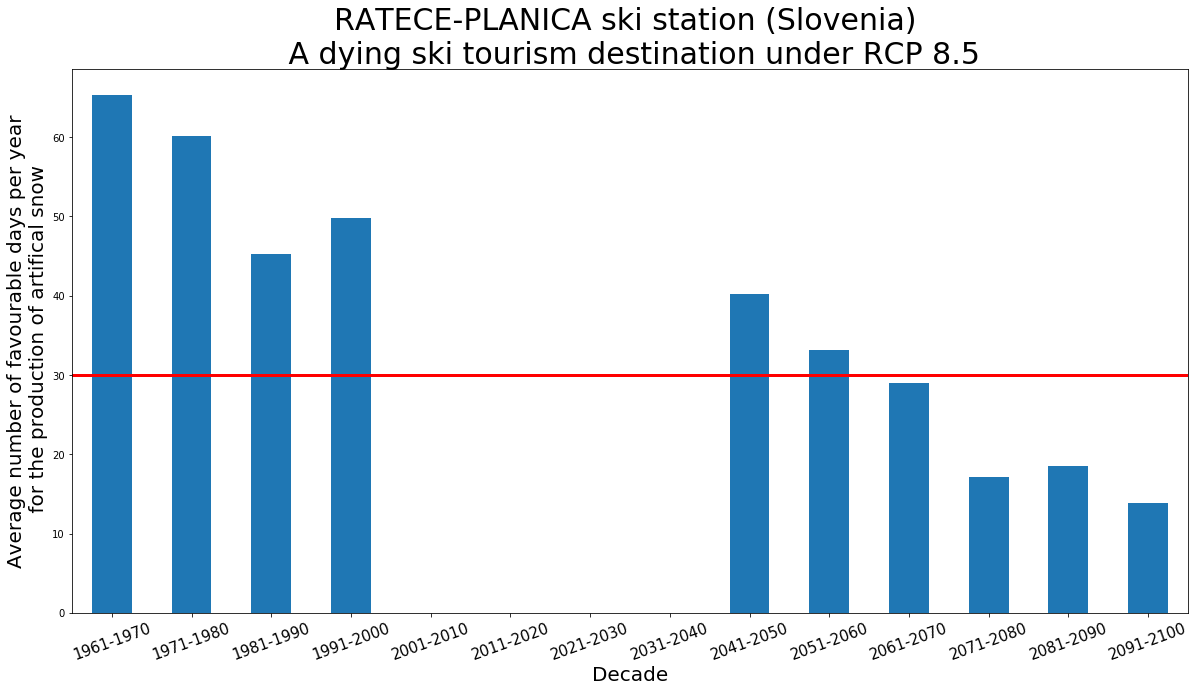

In [305]:
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

fig = plt.figure(1, figsize=[20,10])
ax = plt.subplot(1, 1, 1)
series10YS.plot.bar(ax=ax)
plt.axhline(y=30, color='r', linestyle='-', linewidth=3)
labels = [datetime.strptime(item.get_text(), '%Y-%m-%d %H:%M:%S').strftime("%Y") + '-' + 
            (datetime.strptime(item.get_text() , '%Y-%m-%d %H:%M:%S') +  relativedelta(years=9)).strftime("%Y")  for item in ax.get_xticklabels()] 
ax.set_xticklabels(labels, rotation=20, fontsize = 15)
ax.set_xlabel('Decade', fontsize = 20)
ax.set_ylabel('Average number of favourable days per year\n for the production of artifical snow', fontsize = 20)
plt.title("RATECE-PLANICA ski station (Slovenia) \n A dying ski tourism destination under RCP 8.5", fontsize=30)